In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from cf_model import MLPCollaborativeFilter
from dataset import ColFDataset, Encoder, split_data
import import_ipynb
import db
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import sqlite3

importing Jupyter notebook from db.ipynb
best_col_model_checkpoint.pth		main.py
best_contentfiltermodel_checkpoint.pth	menv
best_model_checkpoint.pth		mlruns
best_model_state.pth			models
cf_model.py				movie.py
config.py				path_to_your_database.db
dataset.py				__pycache__
db.ipynb				q.py
Dockerfile				README.md
done.txt				requirements.txt
encoder.pkl				server
fdstests.ipynb				test.db
filemanager.py				testsources.ipynb
holocenemodels				todo.txt
indie_letterboxd.db			train_colfilter.ipynb
indie_letterboxd_v2.db			train_confilter.ipynb
letterboxd				user.py
letterboxd.db				wandb
main.ipynb				web_spider.py


In [2]:
DB_NAME = 'indie_letterboxd_v2'
db.display_size(DB_NAME)

Users: 2400

Movies: 771

Reviews: 18504


In [3]:
conn = sqlite3.connect(DB_NAME+'.db')
cursor = conn.cursor()

# SQL query to fetch user name and ID, movie name and ID, and rating from reviews
query = '''
    SELECT 
        u.user_id,
        u.name AS user_name, 
        m.movie_id,
        m.title AS movie_title, 
        r.rating
    FROM 
        Reviews r
    JOIN Users u ON r.user_id = u.user_id
    JOIN Movies m ON r.movie_id = m.movie_id
    '''

try:
    cursor.execute(query)
    reviews = cursor.fetchall()
    
    # for review in reviews:
    #     print("User ID:", review[0], "| User Name:", review[1], "| Movie ID:", review[2], "| Movie Title:", review[3], "| Rating:", review[4])
except sqlite3.Error as e:
    print("An error occurred:", e)
finally:
    conn.close()

In [4]:
# print(db.display_size())
#TODO change shuffle and not shuffle

# Assuming 'reviews' is a list of tuples and you've already created 'data'
data = [tuple([did[1], did[3], did[-1]]) for did in reviews]

# Shuffle 'data' in place with random.shuffle()
random.shuffle(data)

# Now 'data' is shuffled, and you can work with it
print(data[:10])
#found invalid values earlier.

data = [pre for pre in data if pre[-1] > 0]
data.count(-1)

[('Sr(a). Felix Rosado', 'Saloum', 0.8), ('Фрацил Джогов', 'Love Dad', 0.24), ('Jožefa Mlakar', 'Prisoners Daughter', 0.8), ('Monica Wheeler', 'Alam', 0.6), ('Hunar De', 'The Burnt Orange Heresy', 0.2), ('Dr Wayne Rowe', 'The World Is Family', 0.9), ('Сафонова Зинаида Викторовна', 'Mountain Cat', 0.4), ('Saulītis, Ernests', 'State Funeral', 0.71), ('Lizz Latier-van Es', 'Coming Home Again', 0.4), ('Samuel Oliver', 'My Life as a Comedian', 0.8)]


0

In [5]:
#test data is holdout for Kfolds cross data validation evaluation.
train_data, test_data = split_data(data)
train_data, validation_data = split_data(train_data,0.1)

In [6]:
len(validation_data)

13241

In [7]:
train_users_data = [ud[0] for ud in train_data]
train_movies_data = [md[1] for md in train_data]

## after splitting, only use the training data --- for encoding!!!!

In [8]:
encoder = Encoder(users=train_users_data,movies=train_movies_data)###<---- important
import pickle

# Assuming 'encoder' is your encoder object
with open('encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)


In [9]:
train_ds = ColFDataset(train_data,encoder)
test_ds = ColFDataset(test_data,encoder)
validation_ds = ColFDataset(validation_data,encoder)

In [10]:
len(train_ds.movie_ids)

1471

In [11]:
train_ds.movie_ids.count(0)

0

In [12]:
len(validation_ds.movie_ids)

13241

In [13]:
validation_ds.user_ids.count(0)

7167

In [14]:
validation_ds.movie_ids.count(0)

1869

In [15]:
len(test_ds.movie_ids)

3679

In [16]:
test_ds.movie_ids.count(0)

546

In [17]:
BATCH_SIZE = 64
train_data_loader = DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=False,drop_last=True)
validation_data_loader = DataLoader(validation_ds,batch_size=BATCH_SIZE,shuffle=False,drop_last=True)
test_data_loader = DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=False,drop_last=True)

In [18]:
num_users = len(encoder.vocab_to_idx['users'])
num_movies = len(encoder.vocab_to_idx['movies'])
FEATURES=700
model = MLPCollaborativeFilter(num_users + 1, num_movies + 1, embedding_dim=FEATURES)


LEARNING_RATE = 0.001
criterion = nn.MSELoss()
#weight decay L2 regularization
# optimiser = optim.SGD(model.parameters(), lr=0.001,weight_decay=1e-5)\
L2_REGULARIZATION=0.1
optimiser = optim.SGD(model.parameters(), lr=LEARNING_RATE,weight_decay=L2_REGULARIZATION)
EPOCHS = 100

In [19]:
print(len(data))
len(train_ds)

18391


1471

# EDA 

    Examine the data for patterns, anomalies, or characteristics.
    Check for data quality issues such as missing values, outliers, or incorrect data types. <--- either predropped or imputed.
    Get a sense of the distributions of your variables and the relationships between them.

In [20]:
import pandas as pd


column_names = ['user', 'movie','ratings']

df = pd.DataFrame(data, columns=column_names)

# Display the first few rows of the dataset
print(df.head())

# Get a summary of the dataset
print(df.info())

# Generate descriptive statistics
print(df.describe())


                  user                    movie  ratings
0  Sr(a). Felix Rosado                   Saloum     0.80
1        Фрацил Джогов                 Love Dad     0.24
2        Jožefa Mlakar       Prisoners Daughter     0.80
3       Monica Wheeler                     Alam     0.60
4             Hunar De  The Burnt Orange Heresy     0.20
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18391 entries, 0 to 18390
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user     18391 non-null  object 
 1   movie    18391 non-null  object 
 2   ratings  18391 non-null  float64
dtypes: float64(1), object(2)
memory usage: 431.2+ KB
None
            ratings
count  18391.000000
mean       0.674751
std        0.210540
min        0.020000
25%        0.540000
50%        0.700000
75%        0.800000
max        1.000000


In [21]:
print(df.isnull().sum())


user       0
movie      0
ratings    0
dtype: int64


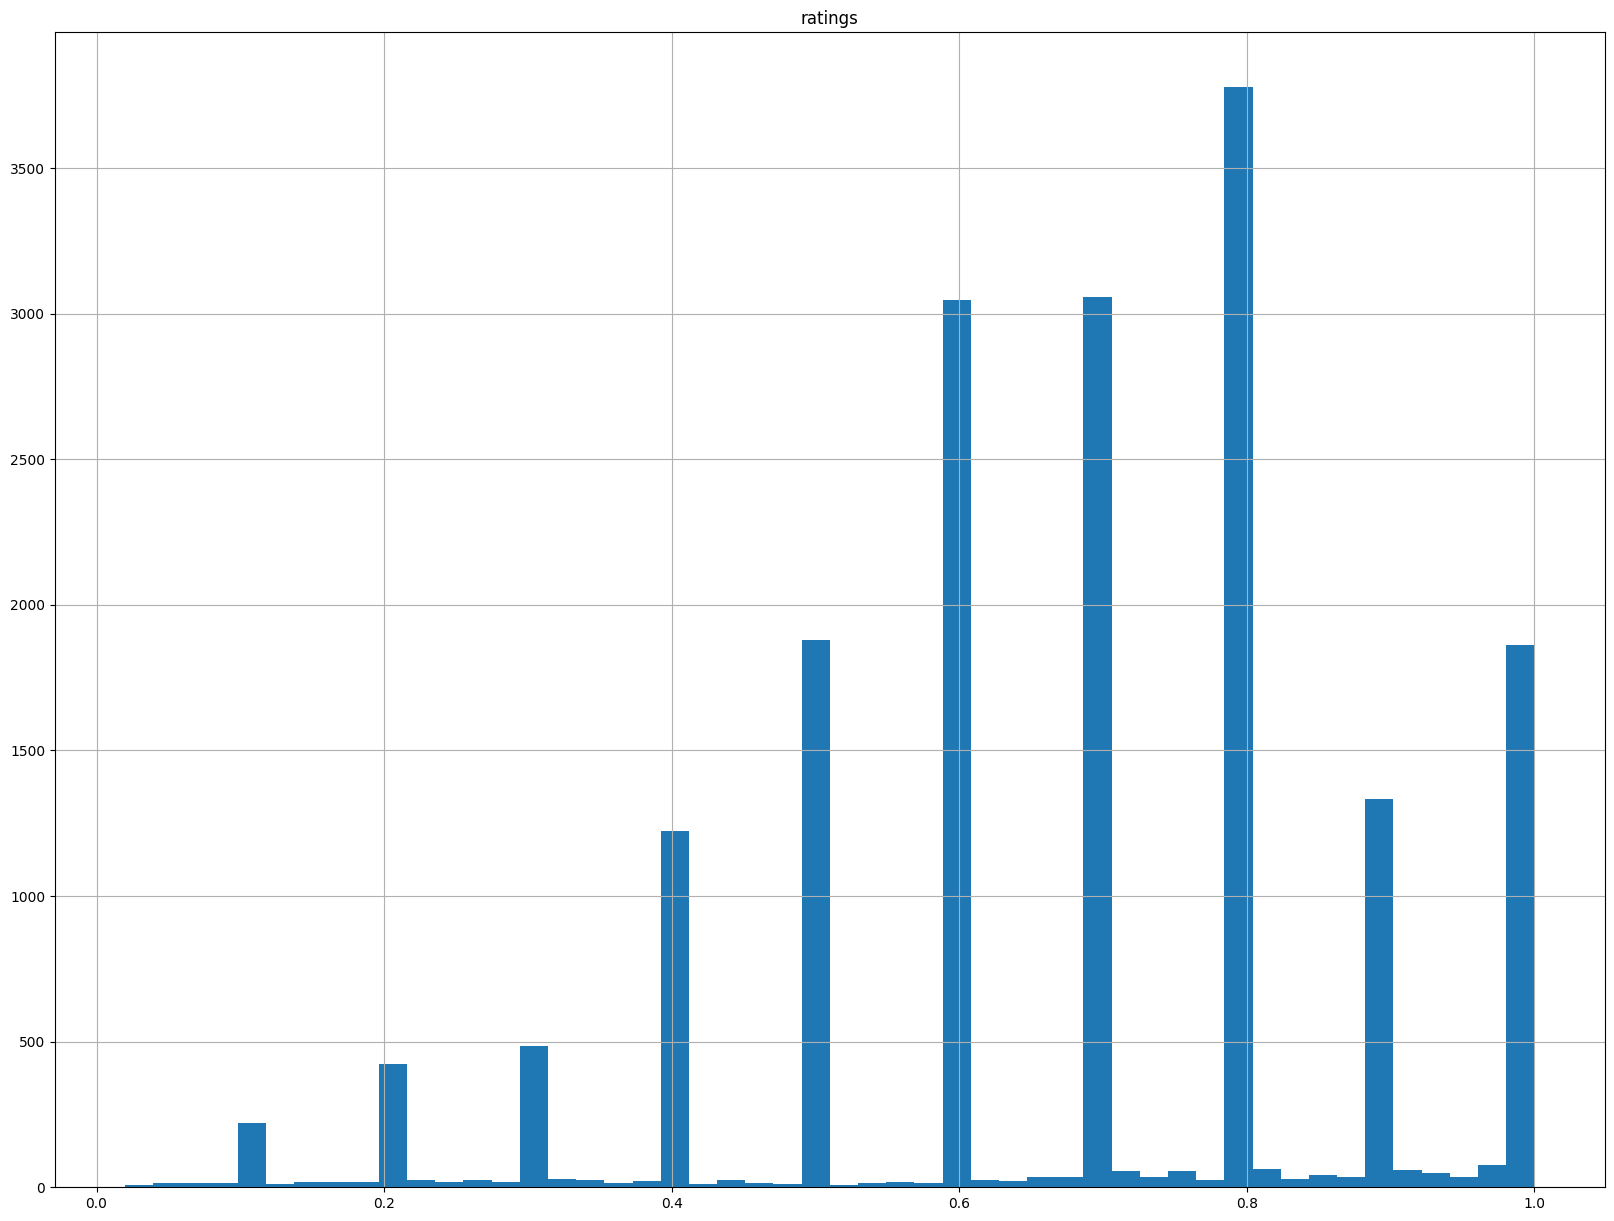

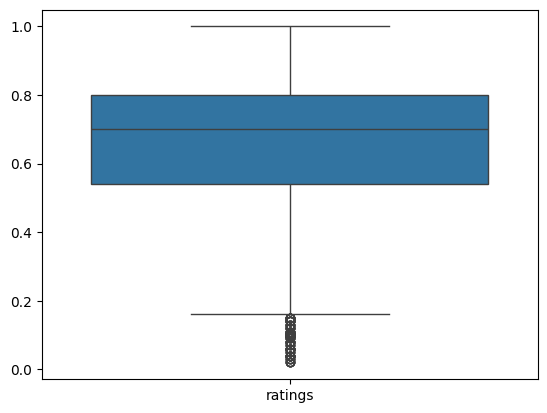

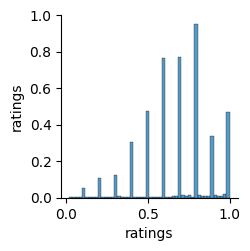

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms for numeric features
df.hist(bins=50, figsize=(20,15))
plt.show()

# Box plots for distributions and spotting outliers
sns.boxplot(data=df)
plt.show()

# Pairplot to visualize pairwise relationships between features
sns.pairplot(df)
plt.show()


In [23]:
df[df['ratings'] == -1]

,user,movie,ratings


In [24]:
df['title_length'] = df['movie'].str.len()
df['title_length'].head()

0     6
1     8
2    18
3     4
4    23
Name: title_length, dtype: int64

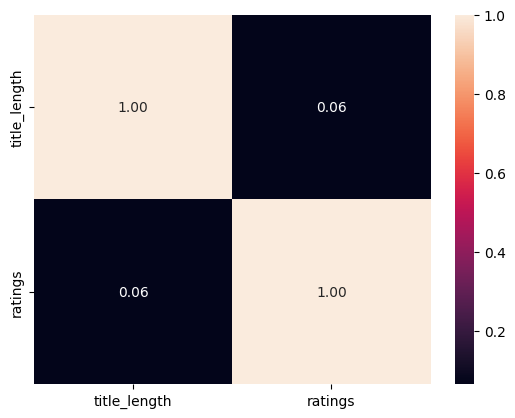

In [25]:

df['title_length']
# Correlation matrix

corr_matrix = df[['title_length','ratings']].corr()

# Heatmap of the correlation matrix
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

# Specifically look at correlations with the target variable if defined
# target_corr = corr_matrix["YourTargetVariable"].sort_values(ascending=False)
# print(target_corr)


In [26]:
# Example of finding outliers for a 'feature_name'
Q1 = df['ratings'].quantile(0.25)
Q3 = df['ratings'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)
outlier_condition = ((df['ratings'] < (Q1 - 1.5 * IQR)) | (df['ratings'] > (Q3 + 1.5 * IQR)))
outliers = df[outlier_condition]
print(outliers)

0.26
                            user                    movie  ratings  \
99               მზია ქევხიშვილი         Dear Evan Hansen     0.10   
130          Пейолина Пенджакова                 Daliland     0.10   
241             Гаврило Ґжицький                 Synonyms     0.10   
298                 Arne Hansson         The Moneychanger     0.09   
312    Dr. Feketené Orbán Margit           Spring Blossom     0.10   
...                          ...                      ...      ...   
18174                        윤영미          The Hummingbird     0.10   
18213        ललित बालासुब्रमणियम                Baby Ruby     0.10   
18270            सत्यव्रता रिमाल               Good Madam     0.10   
18369             ლიკა გურგენიძე                   Zalava     0.10   
18378              Vilém Růžička  Hate to Love Nickelback     0.10   

       title_length  
99               16  
130               8  
241               8  
298              16  
312              14  
...             ...  


## MLFLOw

In [27]:
import mlflow
from mlflow.tracking import MlflowClient

# Optional: Set MLflow experiment
mlflow.set_experiment("Finetuned Collaborative Filter")

<Experiment: artifact_location='file:///home/james/Desktop/torchex/movie-users/mlruns/827152334394031969', creation_time=1710099404696, experiment_id='827152334394031969', last_update_time=1710099404696, lifecycle_stage='active', name='Finetuned Collaborative Filter', tags={}>

In [28]:
# Log model parameters (example)
mlflow.start_run()
mlflow.log_param("epochs", EPOCHS)
mlflow.log_param("optimizer", type(optimiser).__name__)
mlflow.log_param("learning rate", LEARNING_RATE)
mlflow.log_param("batch size", BATCH_SIZE)
mlflow.log_param("L2 regularization", L2_REGULARIZATION)
mlflow.log_param("drop out", 0.5)

0.5

# PRETEST

In [29]:
#test data
model.eval()  # Switch to evaluation mode
test_loss = 0
correct_predictions = 0  # Fixed variable name for clarity
total_contexts = 0

with torch.no_grad():  # Disable gradient computation
    for user_ids, movie_ids, ratings in test_data_loader:
        predictions = model(user_ids,movie_ids)  # Generate predictions
        # Calculate and accumulate loss
        loss = criterion(predictions, ratings)
        test_loss += loss.item()
        

test_loss /= len(test_data_loader)  # Average loss per batch

print(test_loss)

mlflow.log_metric('pretraining test loss',test_loss)

0.8345452013768648


## wandb

In [30]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    entity="jcrich",
    project="collaborative filter model",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": LEARNING_RATE,
    "architecture": "collaborative filter",
    "dataset": "imdb",
    "epochs": EPOCHS,
    }
)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jcrich. Use `wandb login --relogin` to force relogin


In [31]:
# Initialize lists to keep track of losses and epochs
# Initialize MLflow run
# Initialize MLflow run
# Initialize MLflow run

train_losses = []
validation_losses = []
epochs = []

# Set the best validation loss to infinity at the start
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    model.train()
    total_epoch_loss = 0
    for batch_idx, (user_ids, movie_ids, ratings) in tqdm(enumerate(train_data_loader), total=len(train_data_loader), desc=f'Epoch {epoch}'):

        optimiser.zero_grad()
        predictions = model(user_ids, movie_ids)
        loss = criterion(predictions, ratings)

        loss.backward()
        optimiser.step()
        
        batch_loss = loss.item()
        total_epoch_loss += batch_loss
        
    # After all batches, calculate average loss for the epoch
    avg_epoch_loss = total_epoch_loss / len(train_data_loader)
    train_losses.append(avg_epoch_loss)
    epochs.append(epoch)
    
    # Log training loss for the current epoch
    wandb.log({"Training Loss": avg_epoch_loss, "Epoch": epoch})
    mlflow.log_metric("Training Loss", avg_epoch_loss, step=epoch)

    # Start validation phase
    model.eval()
    total_validation_loss = 0
    with torch.no_grad():
        for batch_idx, (user_ids, movie_ids, ratings) in enumerate(validation_data_loader):
            predictions = model(user_ids, movie_ids)
            loss = criterion(predictions, ratings)
            total_validation_loss += loss.item()
    
    # Calculate and log validation loss after the epoch
    avg_validation_loss = total_validation_loss / len(validation_data_loader)
    validation_losses.append(avg_validation_loss)

    # Save the model if this epoch has the best validation loss so far
    if avg_validation_loss < best_val_loss:
        best_val_loss = avg_validation_loss
        mlflow.log_metric("Best Validation Loss", best_val_loss, step=epoch)
        mlflow.pytorch.log_model(model, "model")
        # Save model state
        torch.save(model.state_dict(), 'best_model_state.pth')
        # If you also want to save the optimizer state along with the model:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimiser_state_dict': optimiser.state_dict(),
            'loss': avg_validation_loss,
        }, 'best_col_model_checkpoint.pth')
        # Log the model checkpoint as an artifact
        mlflow.log_artifact('best_col_model_checkpoint.pth')
    
    # Log validation loss for the current epoch
    wandb.log({"Validation Loss": avg_validation_loss, "Epoch": epoch})
    mlflow.log_metric("Validation Loss", avg_validation_loss, step=epoch)
    
# Finish the Weights & Biases run
wandb.finish()

Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 241.79it/s]
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Training Loss,█▅▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,99
Training Loss,0.0598
Validation Loss,0.09444


In [32]:
#test data
model.eval()  # Switch to evaluation mode
test_loss = 0
correct_predictions = 0  # Fixed variable name for clarity
total_contexts = 0

with torch.no_grad():  # Disable gradient computation
    for user_ids, movie_ids, ratings in test_data_loader:
        predictions = model(user_ids,movie_ids)  # Generate predictions
        # Calculate and accumulate loss
        loss = criterion(predictions, ratings)
        test_loss += loss.item()
        
        # # Reshape predictions to match [batch_size, context_size, vocab_size]
        # predictions = predictions.view(-1, context_size, VOCAB_SIZE)
        
        # # Get top prediction for each context position
        # top_predictions = predictions.argmax(dim=2)
        
        # # Calculate correct predictions
        # correct_preds = (top_predictions == context).float().sum()
        # correct_predictions += correct_preds.item()  # Accumulate correct predictions
        
        # total_contexts += context.numel()  # Total number of context word positions evaluated

# Calculate final metrics
test_loss /= len(test_data_loader)  # Average loss per batch
# print('correct predictions = ',correct_predictions)
# print('out of  = ',total_contexts)
# accuracy = correct_predictions / total_contexts  # Compute accuracy

# print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')

# Evaluate the model
# (This would involve using a separate validation set or performing cross-validation)
print(test_loss)

mlflow.log_metric('Post training test loss',test_loss)
mlflow.end_run()

0.09750499393333469


# Validation

In [33]:
#SPLit
from sklearn.model_selection import KFold

# Configuration
num_folds = 10
data_size = len(test_ds)  # Assuming 'dataset' is a PyTorch Dataset

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

In [34]:
# Optional: Set MLflow experiment
mlflow.set_experiment("Finetuned Collaborative Filter")
# Log model parameters (example)
mlflow.start_run()
mlflow.log_param("epochs", EPOCHS)
mlflow.log_param("optimizer", type(optimiser).__name__)
mlflow.log_param("learning rate", LEARNING_RATE)
mlflow.log_param("batch size", BATCH_SIZE)
mlflow.log_param("L2 regularization", L2_REGULARIZATION)
mlflow.log_param("KFOLDS", num_folds)
mlflow.log_param("drop out", 0.5)

0.5

In [35]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    entity="jcrich",
    project="collaborative filter model",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": LEARNING_RATE,
    "architecture": "collaborative filter",
    "dataset": "letterboxd",
    "epochs": EPOCHS,
    }
)

In [37]:
# Correct variable names and logic
for fold, (train_ids, val_ids) in enumerate(kfold.split(train_ds)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

    trainloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=train_subsampler)
    valloader = torch.utils.data.DataLoader(validation_ds, batch_size=BATCH_SIZE, sampler=val_subsampler)

    model = MLPCollaborativeFilter(num_users + 1, num_movies + 1, embedding_dim=FEATURES)
    optimiser = torch.optim.SGD(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        for user_indices, item_indices, ratings in trainloader:
            optimiser.zero_grad()
            outputs = model(user_indices, item_indices).squeeze()
            loss = criterion(outputs, ratings)
            loss.backward()
            optimiser.step()
            train_loss += loss.item()

        # Average training loss over all batches
        train_loss /= len(trainloader)
        # Log training loss for the current epoch
        wandb.log({"Avg. Training Loss": train_loss, "Epoch": epoch})
        mlflow.log_metric("Avg. Training Loss", train_loss, step=epoch)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for user_indices, item_indices, ratings in valloader:
                outputs = model(user_indices, item_indices).squeeze()
                loss = criterion(outputs, ratings)
                val_loss += loss.item()

        avg_validation_loss = val_loss / len(valloader)
        print(f'Validation Loss for fold {fold}: {avg_validation_loss}')
        
        if avg_validation_loss < best_val_loss:
            best_val_loss = avg_validation_loss
            mlflow.log_metric("Best Validation Loss", best_val_loss, step=epoch)
            mlflow.pytorch.log_model(model, "model")
            # Save model state
            torch.save(model.state_dict(), 'best_model_state.pth')
            # If you also want to save the optimizer state along with the model:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimiser_state_dict': optimiser.state_dict(),
                'loss': avg_validation_loss,
            }, 'best_col_model_checkpoint.pth')
            # Log the model checkpoint as an artifact
            mlflow.log_artifact('best_col_model_checkpoint.pth')
        
        # Log validation loss for the current epoch
        wandb.log({"Avg Validation Loss": avg_validation_loss, "Epoch": epoch})
        mlflow.log_metric("Avg Validation Loss", avg_validation_loss, step=epoch)
    
    print('--------------------------------')





wandb.finish()

FOLD 0
--------------------------------
Validation Loss for fold 0: 0.40004058678944904
Validation Loss for fold 0: 0.3405859172344208
Validation Loss for fold 0: 0.2523006349802017
Validation Loss for fold 0: 0.19710467755794525
Validation Loss for fold 0: 0.17236324648062387
Validation Loss for fold 0: 0.18156878650188446
Validation Loss for fold 0: 0.1494556019703547
Validation Loss for fold 0: 0.14232215782006583
Validation Loss for fold 0: 0.12940147270758948
Validation Loss for fold 0: 0.1328766867518425
Validation Loss for fold 0: 0.11800055454174678
Validation Loss for fold 0: 0.11020211627086003
Validation Loss for fold 0: 0.10912800580263138
Validation Loss for fold 0: 0.10899850477774937
Validation Loss for fold 0: 0.1046971728404363
Validation Loss for fold 0: 0.11421542366345723
Validation Loss for fold 0: 0.10135728617509206
Validation Loss for fold 0: 0.09762210647265117
Validation Loss for fold 0: 0.10419445981582005
Validation Loss for fold 0: 0.1007133200764656
Valida

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Avg Validation Loss,▃▂▂▁█▃▂▁▄▂▂▂▃▂▁▂█▄▃▂▂▂▂▁▂▂▁▁▂▁▁▁▃▂▂▁▃▂▂▂
Avg. Training Loss,▆▂▁▁█▃▂▁█▃▂▂▅▂▂▁█▂▂▁▅▂▁▁▄▂▁▁▃▂▁▁▅▂▁▁▄▂▁▁
Epoch,▁▃▅▇▁▃▅▇▁▃▅▇▂▃▅▇▁▄▆▇▂▃▅█▂▄▆▇▂▄▆█▂▄▆█▂▄▆█
Avg Validation Loss,0.07214
Avg. Training Loss,0.05818
Epoch,99


In [38]:
#test data
model.eval()  # Switch to evaluation mode
test_loss = 0
correct_predictions = 0  # Fixed variable name for clarity
total_contexts = 0

with torch.no_grad():  # Disable gradient computation
    for user_ids, movie_ids, ratings in test_data_loader:
        predictions = model(user_ids,movie_ids)  # Generate predictions
        # Calculate and accumulate loss
        loss = criterion(predictions, ratings)
        test_loss += loss.item()
        
        # # Reshape predictions to match [batch_size, context_size, vocab_size]
        # predictions = predictions.view(-1, context_size, VOCAB_SIZE)
        
        # # Get top prediction for each context position
        # top_predictions = predictions.argmax(dim=2)
        
        # # Calculate correct predictions
        # correct_preds = (top_predictions == context).float().sum()
        # correct_predictions += correct_preds.item()  # Accumulate correct predictions
        
        # total_contexts += context.numel()  # Total number of context word positions evaluated

# Calculate final metrics
test_loss /= len(test_data_loader)  # Average loss per batch
# print('correct predictions = ',correct_predictions)
# print('out of  = ',total_contexts)
# accuracy = correct_predictions / total_contexts  # Compute accuracy

# print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')

# Evaluate the model
# (This would involve using a separate validation set or performing cross-validation)
print(test_loss)

mlflow.log_metric('Post training test loss',test_loss)
mlflow.end_run()

0.07417693871416543


## Preference ranking

In [ ]:
target_user_id = 140440102666832

In [ ]:
e_uid = encoder.encode(target_user_id,encoder.user_to_idx)

In [ ]:
def get_user_features(uid):

    for i in range(0,len(all_ds)):

        u,m,r = all_ds[i]
        # print(u)
        if u == uid:
            yield [m,r]
    

In [ ]:
def predict_ratings(e_uid,e_mid,model):
    e_uid_tensor = torch.tensor(e_uid, dtype=torch.int64).unsqueeze(0)
    movie_eid_tensor = torch.tensor(e_mid,dtype=torch.int64).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        user_rating = model(e_uid_tensor,movie_eid_tensor)
        return movie_eid_tensor,user_rating
        
    

In [ ]:
#get user and features
seen_features = set(tuple(fe) for fe in get_user_features(e_uid)) # Get user features if needed
seen_movies = set(sf[0].item() for sf in seen_features)
all_movies = set([num for num in range(30)])
unseen_movies = all_movies - seen_movies
unseen_features = {tuple(predict_ratings(e_uid,um,model)) for um in unseen_movies}
all_features = seen_features | unseen_features

sorted_set = sorted(all_features, key=lambda x: x[1])
top_n = 10
recommendations = list(filter(lambda x: x[0].item() in unseen_movies,sorted_set))
n_recommendations = list(map(lambda x: x[0],recommendations[-1:top_n*-1:-1]))
n_recommendations


# Matching

In [ ]:
#all users, with all movie ratings.
def generate_all_ratings(model,num_users,num_movies):
    #build matrix

    #data already encoded....
    all_data = [['dummy',mnm,unm,'dummy','0/10'] for unm in range(0,num_users) for mnm in range(0,num_movies)]
    # print(all_data)
    # print([em for em in all_data])
    fake_encoder = Encoder([did[2] for did in all_data],[did[1] for did in all_data])
    all_ds = CFDataset(all_data,fake_encoder)
    
    data_loader = DataLoader(all_ds, batch_size=1)
    for uid,mid,ra in data_loader:
        # print(uid,mid)
        prediction = model(uid,mid)
        yield (uid.item(),mid.item(),prediction.item())



In [ ]:
def create_ratings_tensor(data, num_users, num_movies):
    # Initialize an empty tensor to hold the ratings
    ratings_tensor = torch.zeros(num_users, num_movies)
    
    # Iterate over the data and fill the tensor
    for entry in data:
        user_id, movie_id, rating = entry
        # Convert rating to float
        rating = float(rating)
        ratings_tensor[user_id, movie_id] = rating
    
    return ratings_tensor

In [ ]:
# Step 1: Generate Predictions
predictions = [ra for ra in generate_all_ratings(model,num_users,num_movies)]
# print(predictions)
ratings_tensor = create_ratings_tensor(predictions,num_users,num_movies)
print(ratings_tensor)
# predictions[0]

# ratings_tensor.shape

# ratings_tensor[0]

import torch.nn.functional as F

# Assuming predicted_ratings is your tensor of predicted ratings
# predicted_ratings.shape should be (num_users, num_movies)

# # Calculate cosine similarity
# user_similarities = F.cosine_similarity(ratings_tensor, ratings_tensor, dim=1)

# user_similarities

## COSINE SIMILARITY

In [ ]:
# Step 1: Normalize predicted ratings
normalized_ratings = F.normalize(ratings_tensor, p=2, dim=1)

# Step 2: Calculate cosine similarity
user_similarities = torch.matmul(normalized_ratings, normalized_ratings.T)

# Set diagonal elements to a large negative value to exclude self-similarity
user_similarities.fill_diagonal_(-float('inf'))

# You can optionally convert the similarities tensor to a numpy array for easier manipulation
user_similarities_np = user_similarities.numpy()

# Print or use the user similarities tensor
print(user_similarities)

### Matches

In [ ]:
top_matches = {}
for i in range(len(user_similarities)):
    # Sort similarities for the current user i
    ranked_users = torch.argsort(torch.tensor(user_similarities[i]), descending=True)
    # Exclude self from top matches (optional)
    top_matches[i] = ranked_users[ranked_users != i]


In [ ]:
top_matches

In [ ]:
encoder.decode(71,encoder.idx_to_user)

In [ ]:
#decoded

decoded_matches = {encoder.decode(k,encoder.idx_to_user):[encoder.decode(ve,encoder.idx_to_user) for ve in v.tolist()] for k,v in top_matches.items()}
decoded_matches

In [ ]:
# Step 4: Select Top Matches
N = 5  # Number of top matches to select
for user, similar_users in decoded_matches.items():
    decoded_matches[user] = similar_users[:N]

decoded_matches

In [ ]:
#decode....

## FINALLY FIND THE MATCHES....

In [ ]:
target_user = 140440102666832



In [ ]:
decoded_matches[target_user]

In [ ]:
neighbour = 140440115331424

## Now see how they relate to the database...

In [ ]:
reviews = db.get_table_values('Reviews')

In [ ]:
#TODO

In [ ]:
def reviews_info(user_id,reviews):
    # print(db.get_table_values('Users'))
    info = {}
    info[user_id] = list(filter(lambda x :x[0] == user_id,db.get_table_values('Users')))[0][1]

    
    #TODO finish work...
    mov_tab = db.get_table_values('Movies')
    
    for review in reviews:
        mov_id = review[1]
        info[mov_id] = {'title':list(filter(lambda x :x[0] == mov_id,mov_tab))[0][1],'rating':review[4]}
        
    return info
    
    

In [ ]:
target_reviews = list(filter(lambda rv: rv[2] == target_user,reviews))
neighbour_reviews = list(filter(lambda rv: rv[2] == neighbour,reviews))

In [ ]:
tar_info = reviews_info(target_user,target_reviews)
neigh_info = reviews_info(neighbour,neighbour_reviews)

In [ ]:
tar_info

In [ ]:
neigh_info

# SAVE_MODEL

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')